# Predicting Shampoo Sales using a simple Keras based LSTM model

### Import Keras and other libraries

In [35]:
## data processing libraries
import pandas as pd
from pandas import Series
from pandas import DataFrame
import numpy as np
from pandas import read_csv
from pandas import datetime

# plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 9]
import seaborn as sns
sns.set()

# ML frameworks
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# .. with keras using the Tensorflow backend
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from math import sqrt

## define some helper functions

In [36]:
# then define a parser for the datetime data
def parser(x):
    print(x)
    return datetime.strptime('190'+x, '%Y-%m')

# import the data from a specific csv path and return the dataset
def process_data():
    # import the data
    shampoo = read_csv('../lstm/shampoo.csv', skiprows=1, names=['Month','Sales'], parse_dates=[0], squeeze = True) #, index_col=0) #, date_parser=parser)
    shampoo.drop(shampoo.index[len(shampoo)-1], inplace= True)
    shampoo['Month'] = '190' + shampoo['Month']
    shampoo['Month'] = pd.to_datetime(shampoo['Month'], format='%Y-%m')
    shampoo['Sales'] = pd.to_numeric(shampoo['Sales'])
    shampoo.set_index('Month', inplace=True)
    return shampoo

# refactor a timeseries as lag dataset for input to the LSTM model
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(lag, 0, -1)]
    #print(columns)
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

# For real valued input dataset take the difference of row values
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [37]:
# create the dataset from csv file and take a look at it
shampoo = process_data()
shampoo.head()

,Sales
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3


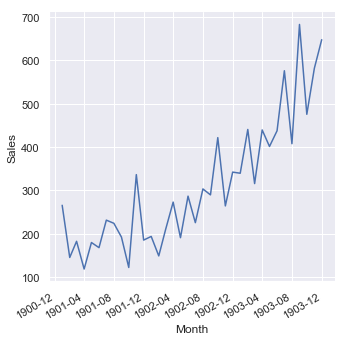

In [38]:
# Plot sales against the month
#plt.plot(shampoo.Sales)
#plt.figure(figsize=(20,30))
g = sns.relplot(x="Month", y="Sales", kind="line", data=shampoo.reset_index())
#g.figure(figsize=(20,30))
g.fig.autofmt_xdate()

In [39]:
# Define the lag interval to use
lag = 2 # 2 here means take the difference every two time steps away
raw_values = shampoo.values
# create the corresponding difference series
diff_shampoo = difference(raw_values, lag)
print(diff_shampoo)

0                   [-82.9]
1      [-26.60000000000001]
2      [-2.799999999999983]
3                    [49.2]
4                    [51.5]
5                    [56.0]
6                   [-39.0]
7                  [-101.6]
8                   [143.7]
9                    [63.0]
10                 [-142.2]
11    [-36.400000000000006]
12     [15.799999999999983]
13     [123.80000000000001]
14     [-18.69999999999999]
15     [13.699999999999989]
16     [34.599999999999994]
17     [16.600000000000023]
18      [63.89999999999998]
19                  [118.0]
20    [-25.399999999999977]
21     [-79.30000000000001]
22      [75.19999999999999]
23      [98.09999999999997]
24     [-23.80000000000001]
25     [-1.099999999999966]
26      [85.40000000000003]
27     [-1.900000000000034]
28                  [174.2]
29    [-29.799999999999955]
30                  [106.5]
31      [67.69999999999999]
32    [-100.70000000000005]
33     [171.59999999999997]
dtype: object


In [40]:
# then convert the series to a dataset
sup_shampoo = timeseries_to_supervised(diff_shampoo, lag)
sup_shampoo.head()
#sup_shampoo.drop(sup_shampoo.index[:lag], inplace=True)

,0,0,0
0,NaN,NaN,[-82.9]
1,NaN,[-82.9],[-26.60000000000001]
2,[-82.9],[-26.60000000000001],[-2.799999999999983]
3,[-26.60000000000001],[-2.799999999999983],[49.2]
4,[-2.799999999999983],[49.2],[51.5]


In [41]:
# change the column names to more descriptive names
sup_shampoo.columns = np.array(['sales_%s'%(x) for x in range(0, lag+1)])
sup_shampoo.head()

,sales_0,sales_1,sales_2
0,NaN,NaN,[-82.9]
1,NaN,[-82.9],[-26.60000000000001]
2,[-82.9],[-26.60000000000001],[-2.799999999999983]
3,[-26.60000000000001],[-2.799999999999983],[49.2]
4,[-2.799999999999983],[49.2],[51.5]


In [42]:
sup_shampoo_values = sup_shampoo.values[lag:,:]
print(sup_shampoo_values.shape)

(32, 3)


In [43]:
# train test split
test_size =  12
train, test = sup_shampoo_values[:-test_size,:], sup_shampoo_values[-test_size:,:]
# then scale the data using the sklearn scaler
scaler, train_scaled, test_scaled = scale(train, test)

/Users/kofi/anaconda/envs/python36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [44]:
def plot_training_stats(param_history, prefix):
    '''
        Expects a param_history dictionary with keys = the different values of the hyperparameter
        prefix: (string) name of the hyperparameter
    '''
    #label_vals = history.keys()
    #labels = ['%s = %d'.format(prefix, x) for x in label_vals]
    metrics = {'mean_squared_error':'Mean Squared Error', 'loss' : 'Loss'}
    
#   if type(history) == list :
#       history = history_list_dataframe(history)
#   else:
#    history = history_list_dataframe(history) if type(history) == list else  history.history

    for metric_key, metric_value in metrics.items():
        # summarize history for loss
        for param_value, history in param_history.items():
            # get back the right history datastructure back
            history = history_list_dataframe(history) if type(history) == list else  history.history
            if metric_key in history:
                plt.plot(history[metric_key], label='%s = %.5f' %(prefix, param_value ))
        plt.title('%s vs. %s' % (metric_value, prefix))
        plt.ylabel(metric_value)
        plt.xlabel('epoch')
        plt.legend(loc='upper left') #['train'], loc='upper left')
        plt.show()

# since we dont have a contiguous history object transform it into a dataframe for plotting 
def history_list_dataframe(history):
    new_data = []
    col_keys = history[0].history.keys() 
    for h in history:
        arr = []
        #print(h)
        for k in h.history.keys():
            #arr.append({k: h.history[k][0]})
            arr.append(h.history[k][0])
        new_data.append(arr) #h.history)
    
    return pd.DataFrame(new_data, columns = col_keys)
        

In [53]:
def fit_lstm(train, batch_size, nb_epoch, neurons, timesteps, adam_opts):
    ''' Define a Sequential LSTM network and provide the modeling parameters &
        hyperparameters. It fits the model on the training data and returns both the model
        and a history object containing the metrics specificied with the selected optimizer
    '''
    # this is a sequence to single value model not a sequence to sequence
    # the y value is  last column of the dataset
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], timesteps, 1)
    model = Sequential()
    # in case we wanted to add a preceding ordinary network layer
    #model.add(Dense(neurons,batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
    #model.add(LSTM(neurons,stateful=True))
    # add the LSTM Layer with the right input size and batch size
    # See https://stackoverflow.com/questions/43882796/when-does-keras-reset-an-lstm-state 
    # for a good explanation of the Stateful= False or True
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    # return a simple dense layer with no activation ==> linear output after the dot product of the weight y = w.x
    model.add(Dense(1))
    adam = Adam(lr=adam_opts['lr'],
                    beta_1=adam_opts['b1'], beta_2=adam_opts['b2'], epsilon=1e-8)
    model.compile(loss='mean_squared_error', optimizer=adam,metrics=['mae', 'mse'])
    run_history = []
    

    for i in range(nb_epoch):
        # states are not cleared and the same state is used for each specific sequence in each batch
        history = model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False,)
        #print('Epoch % : Loss is %'.format(i,history.history['acc']))
        #print([history.  history.history['acc']])
        #plot_training_stats(history)
        run_history.append(history)
        # make sure to reset the state after each epoch
        model.reset_states()
    history = history.history
    print('\t(Loss, MSE, MAE) : (%.5f, %.5f, %.5f)'% 
          (history['loss'][0], history['mean_squared_error'][0] , history['mean_absolute_error'][0] ))
    #print('Final MSE: %.3f' % (history['mean_squared_error'][0]))
    #print('Final MAE: %.3f' % (history['mean_absolute_error'][0]))
    return (model, run_history)

In [54]:
## Functions to reverse data prep steps for prediction
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# inverse scaling for a forecasted value
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, len(X), 1)
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [55]:
# Function to return the rmse for the test data
def get_test_rmse():
    predictions = list()
    error_scores = list()
    for i in range(len(test_scaled)):
        # predict
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        # report performance
    #print('%d) Test RMSE: %.3f' % (1+1, rmse))
    rmse = sqrt(mean_squared_error(raw_values[-test_size:], np.array(predictions)))
    error_scores.append(rmse)
    
    return rmse

In [56]:
# define the LSTM model parameters
batch_size = 1
nb_epochs = [100,1000, 3000]
neurons = [20,100,500]
adam_opts = [{'lr':.001, 'b1': 0.9, 'b2':0.999}, 
             {'lr':.01, 'b1': 0.9, 'b2':0.999},
             {'lr':.1, 'b1': 0.9, 'b2':0.999}]

Starting model fit for lr: 0.001000
	(Loss, MSE, MAE) : (0.00000, 0.00000, 0.00000)
		Test RMSE: 171.029
Starting model fit for lr: 0.010000
	(Loss, MSE, MAE) : (0.00226, 0.00226, 0.03826)
		Test RMSE: 164.052
Starting model fit for lr: 0.100000
	(Loss, MSE, MAE) : (0.29218, 0.29218, 0.42435)
		Test RMSE: 130.554


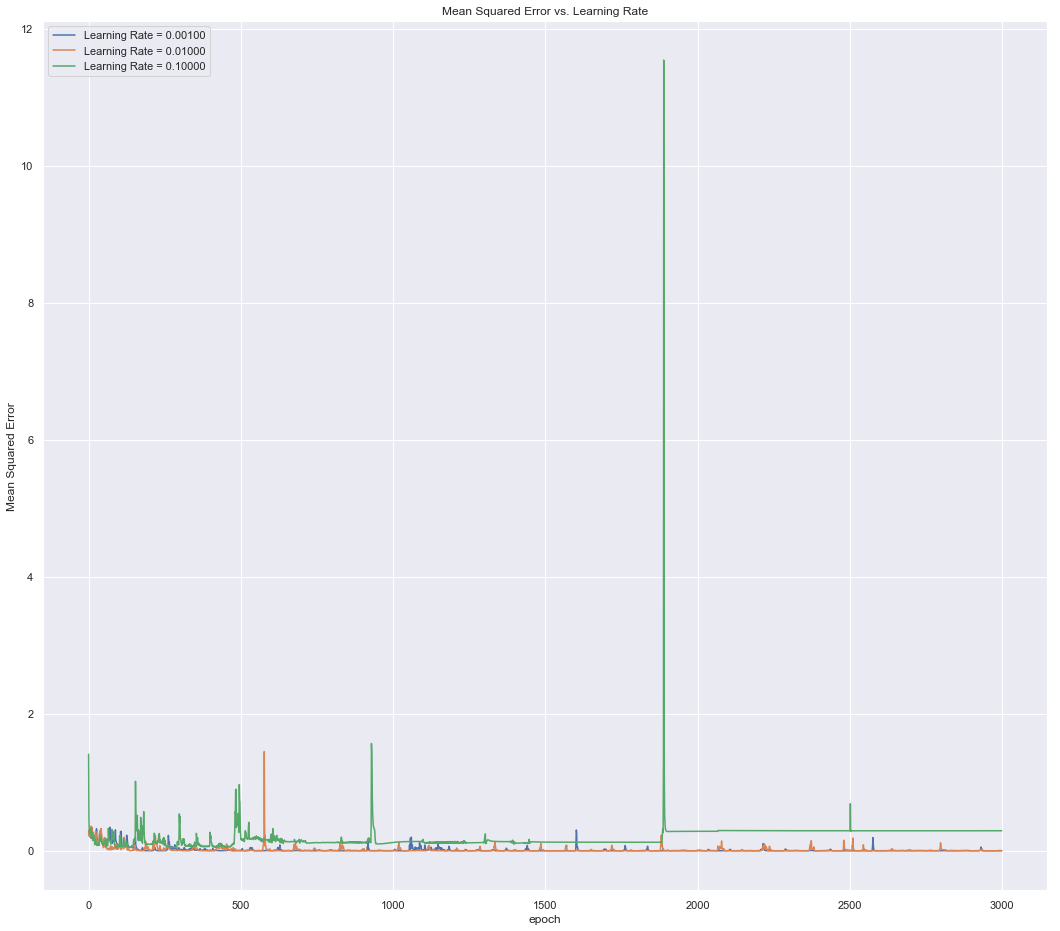

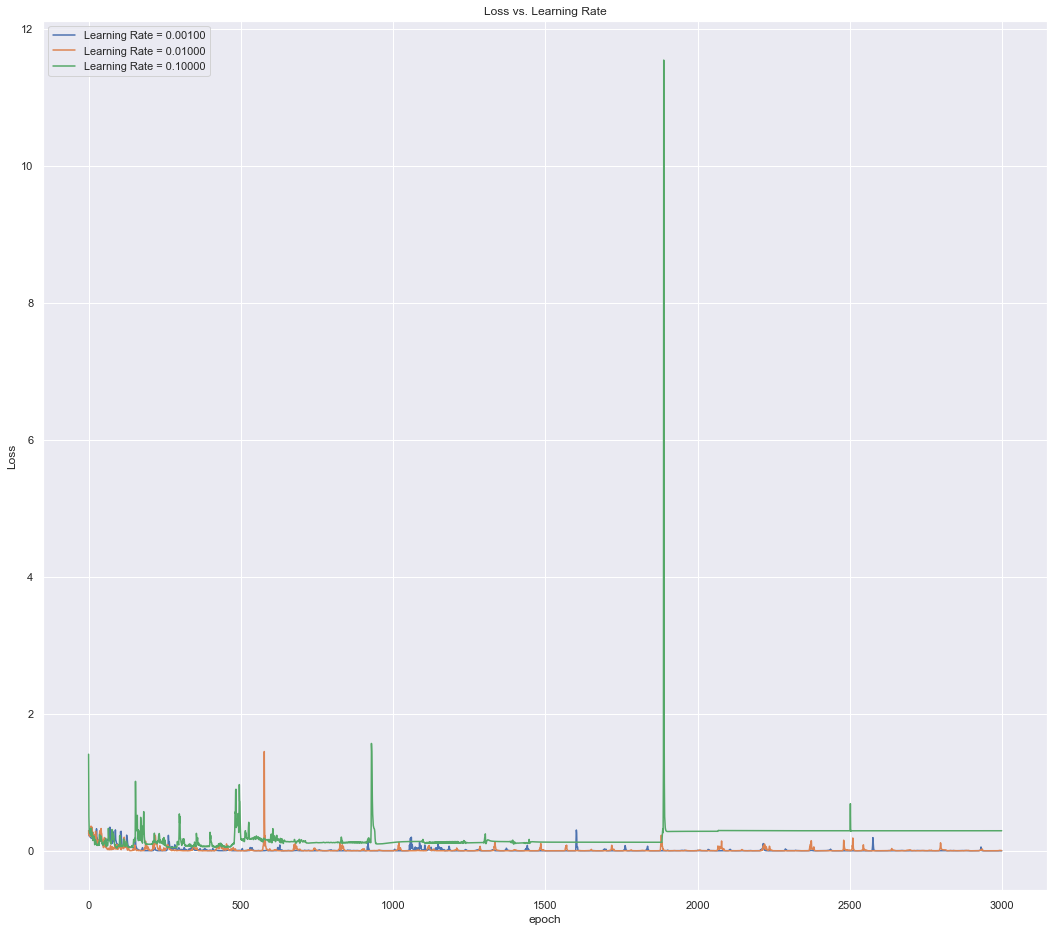

In [57]:
# Explore the impact of the Learning Rate
all_history = {}

for a_opt in adam_opts:
    print('Starting model fit for lr: %6f' % (a_opt['lr']))
    # fit the base model
    lstm_model, h = fit_lstm(train_scaled, batch_size, 3000, 100, lag, a_opt)
    all_history[a_opt['lr']]= h
    test_rmse = get_test_rmse()
    test_rmse = get_test_rmse()
    print('\t\tTest RMSE: %.3f' % (test_rmse))
    
#then plot the results
plot_training_stats(all_history, 'Learning Rate')

Starting model fit for epochs: 100.000000
	(Loss, MSE, MAE) : (0.13985, 0.13985, 0.27590)
		Test RMSE: 148.313
Starting model fit for epochs: 1000.000000
	(Loss, MSE, MAE) : (0.00069, 0.00069, 0.01573)
		Test RMSE: 202.087
Starting model fit for epochs: 3000.000000
	(Loss, MSE, MAE) : (0.01942, 0.01942, 0.11262)
		Test RMSE: 169.231


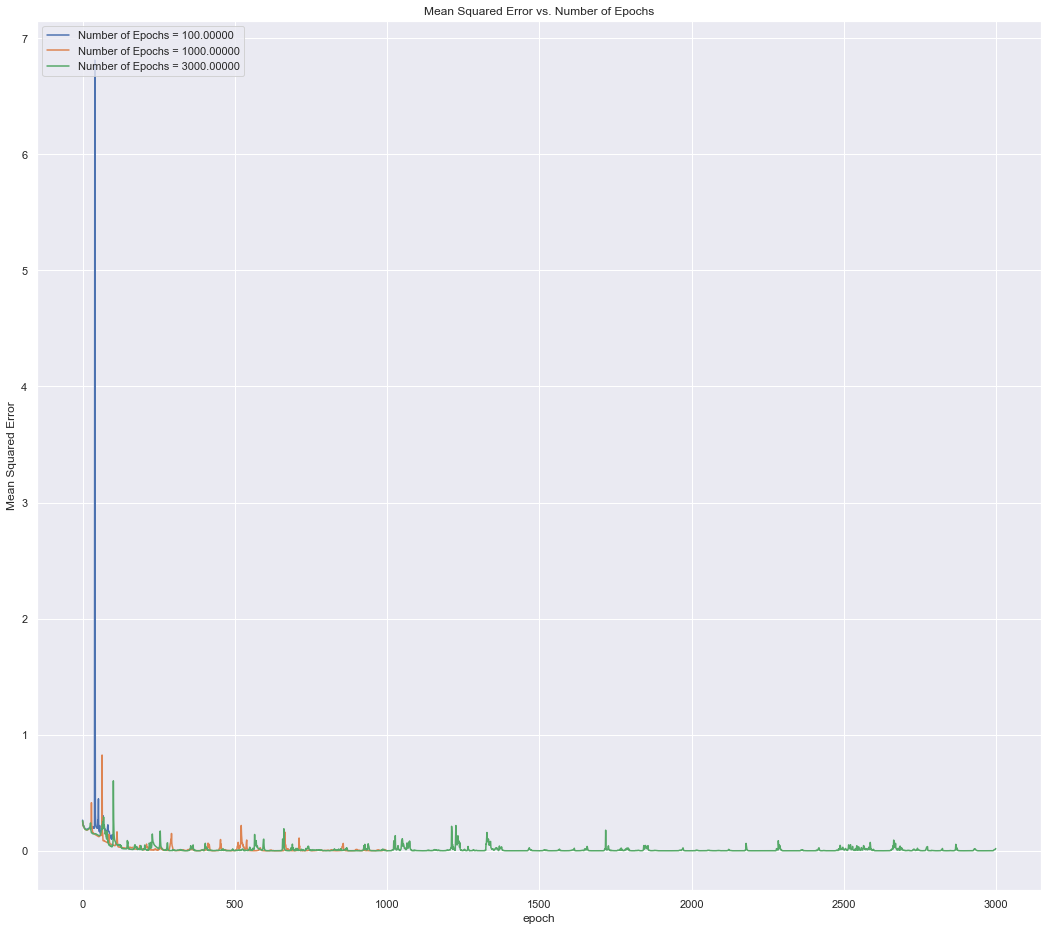

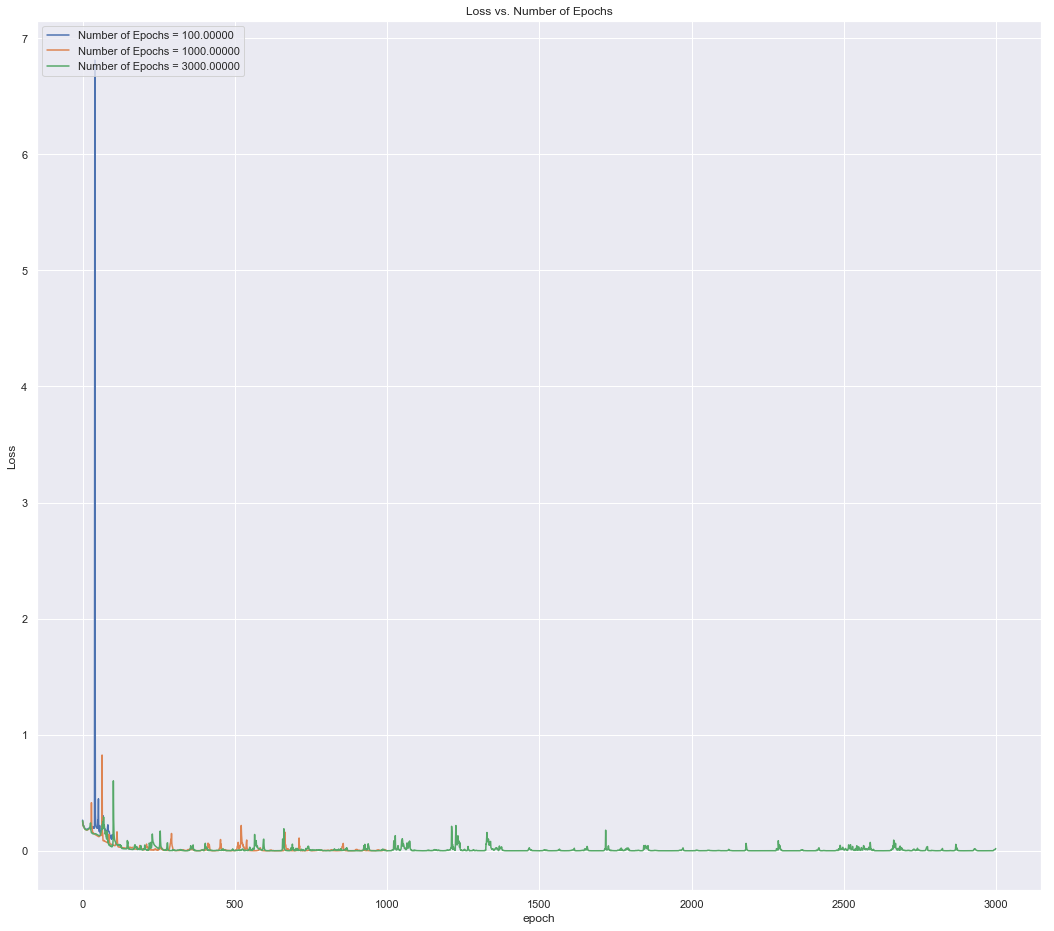

In [58]:
# Explore the impact of the Number of Epochs
all_history = {}

for ep in nb_epochs:
    print('Starting model fit for epochs: %3f' % (ep))
    # fit the base model
    lstm_model, h = fit_lstm(train_scaled, batch_size, ep, 100, lag, {'lr':.001, 'b1': 0.9, 'b2':0.999} )
    all_history[ep]= h
    test_rmse = get_test_rmse()
    print('\t\tTest RMSE: %.3f' % (test_rmse))
    
#then plot the results
plot_training_stats(all_history, 'Number of Epochs')

Starting model fit for neurons: 20.000000
	(Loss, MSE, MAE) : (0.00000, 0.00000, 0.00000)
		Test RMSE: 142.042
Starting model fit for neurons: 100.000000
	(Loss, MSE, MAE) : (0.00458, 0.00458, 0.04980)
		Test RMSE: 168.254
Starting model fit for neurons: 500.000000
	(Loss, MSE, MAE) : (0.00008, 0.00008, 0.00483)
		Test RMSE: 174.252


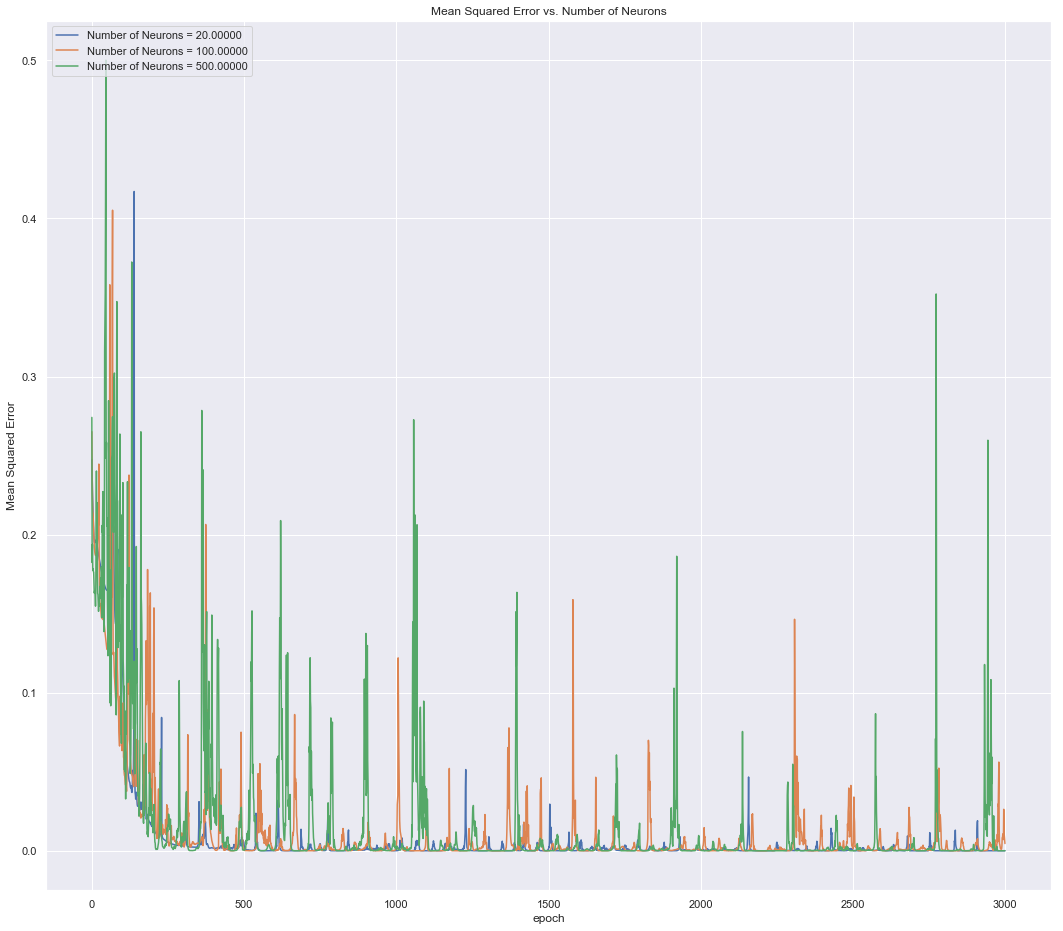

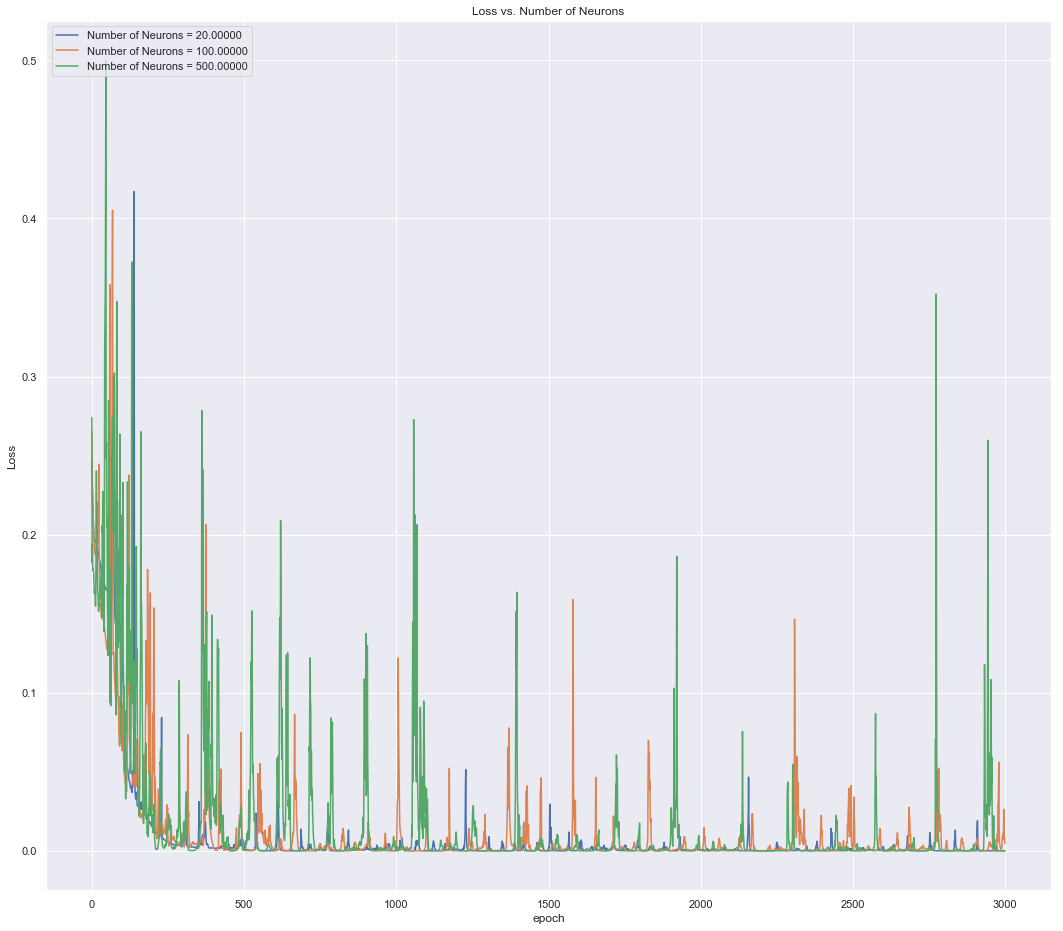

In [59]:
# Explore the impact of the Number of Neurons
all_history = {}

for ne in neurons:
    print('Starting model fit for neurons: %3f' % (ne))
    # fit the base model
    lstm_model, h = fit_lstm(train_scaled, batch_size, 3000, ne, lag, {'lr':.001, 'b1': 0.9, 'b2':0.999} )
    all_history[ne]= h
    test_rmse = get_test_rmse()
    print('\t\tTest RMSE: %.3f' % (test_rmse))
    
#then plot the results
plot_training_stats(all_history, 'Number of Neurons')

	(Loss, MSE, MAE) : (0.08239, 0.08239, 0.20900)
		Test RMSE: 144.207


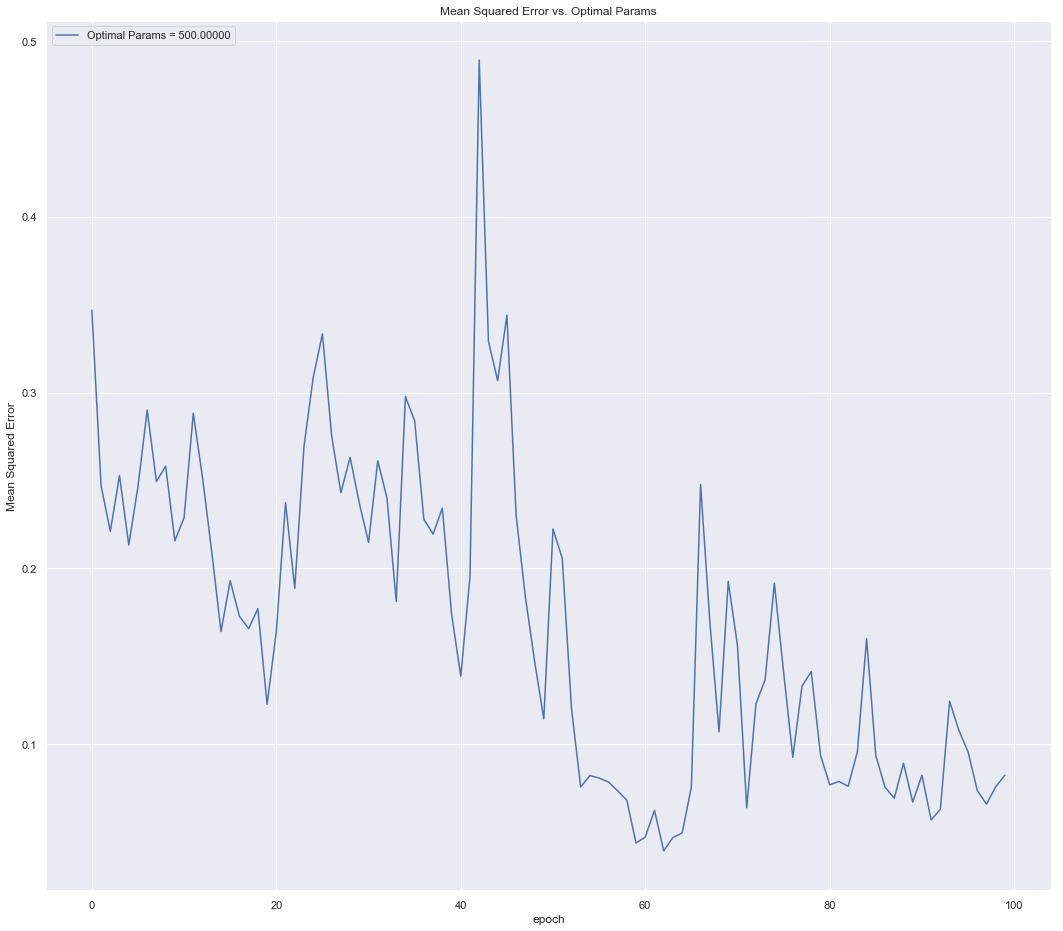

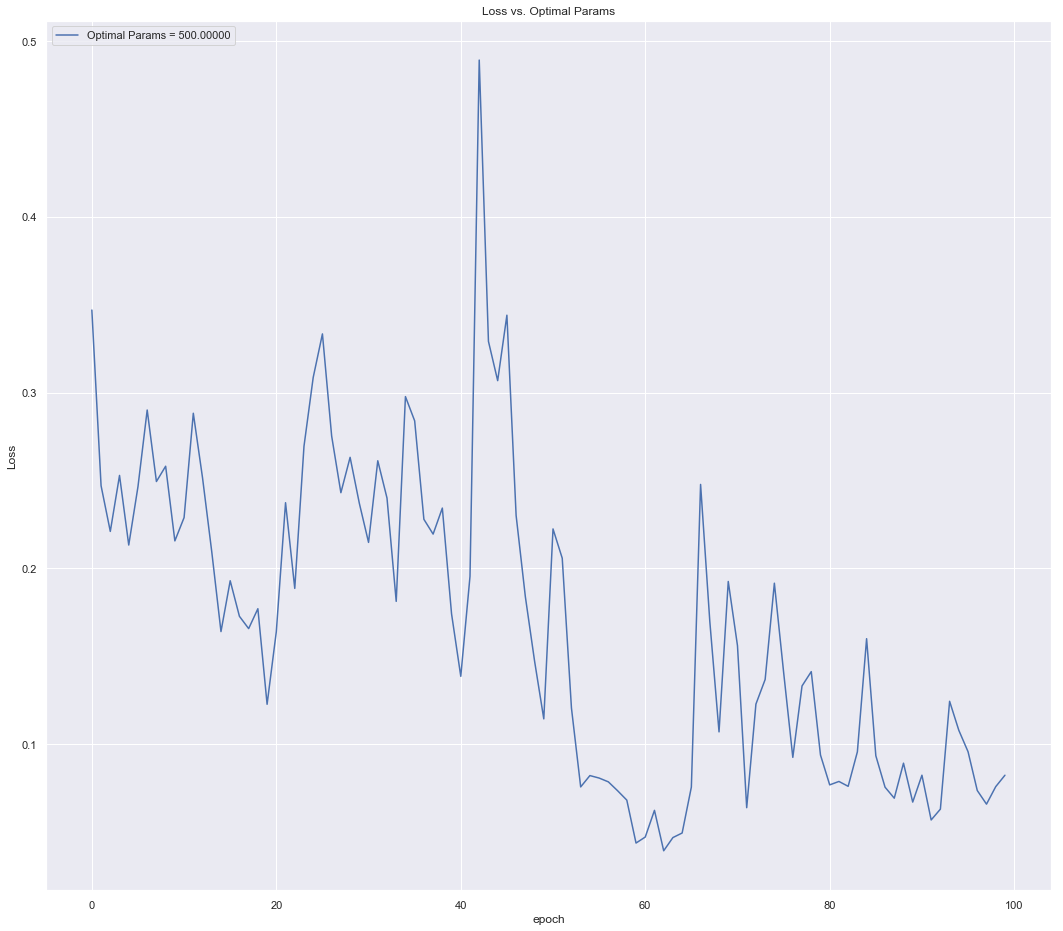

In [60]:
# Seems best options are few neurons, few epochs and large lr are good for test performance
all_history = {}

# fit the base model
lstm_model, h = fit_lstm(train_scaled, batch_size, 100, 20, lag, {'lr':.1, 'b1': 0.9, 'b2':0.999} )
all_history[ne]= h
test_rmse = get_test_rmse()
print('\t\tTest RMSE: %.3f' % (test_rmse))
    
#then plot the results
plot_training_stats(all_history, 'Optimal Params')

	(Loss, MSE, MAE) : (0.07775, 0.07775, 0.22550)
		Test RMSE: 179.601


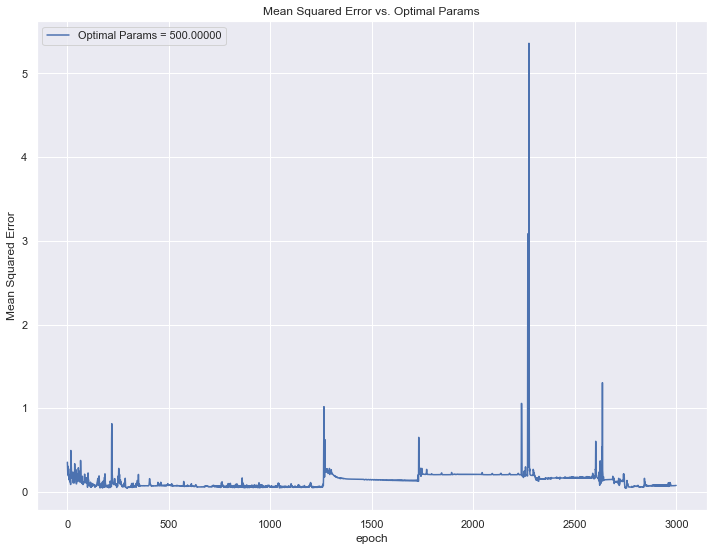

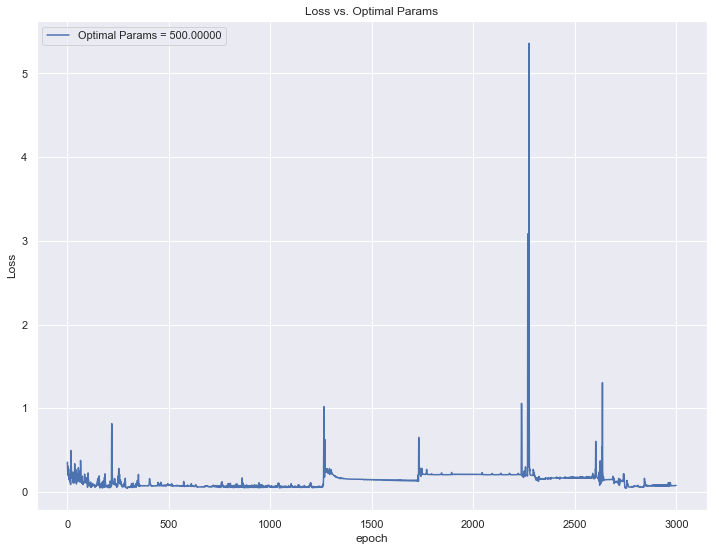

In [62]:
# but few epochs doesnt provide asymptotic convergence .. lets try with the 3000 epochs
all_history = {}
plt.rcParams['figure.figsize'] = [12, 9]

# fit the base model
lstm_model, h = fit_lstm(train_scaled, batch_size, 3000, 20, lag, {'lr':.1, 'b1': 0.9, 'b2':0.999} )
all_history[ne]= h
test_rmse = get_test_rmse()
print('\t\tTest RMSE: %.3f' % (test_rmse))
    
#then plot the results
plot_training_stats(all_history, 'Optimal Params')

	(Loss, MSE, MAE) : (0.04954, 0.04954, 0.19038)
		Test RMSE: 169.815


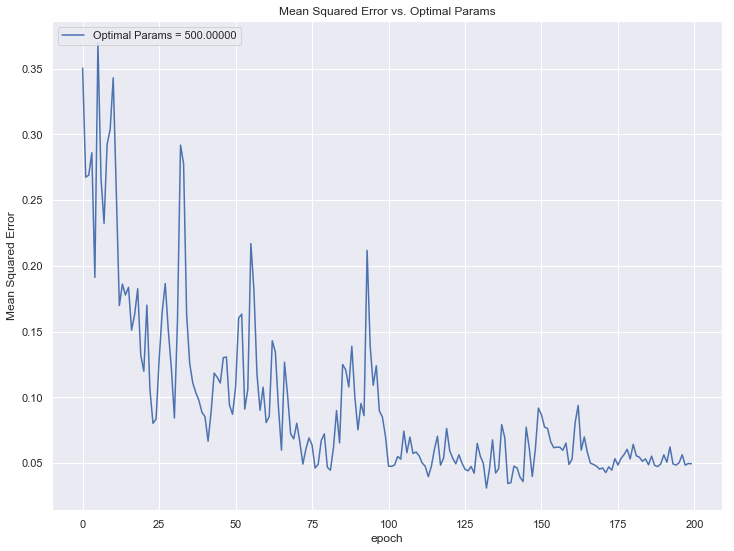

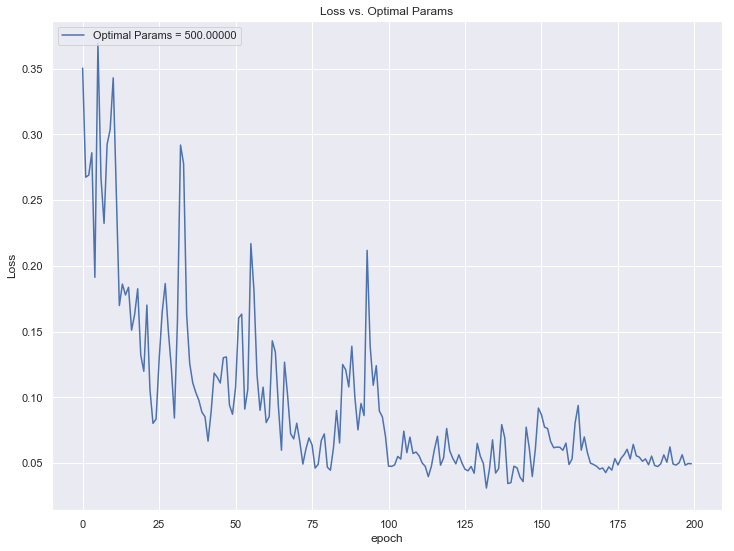

In [63]:
# 3000 epochs looks like it is overfitting how about 200
all_history = {}
plt.rcParams['figure.figsize'] = [12, 9]

# fit the base model
lstm_model, h = fit_lstm(train_scaled, batch_size, 200, 20, lag, {'lr':.1, 'b1': 0.9, 'b2':0.999} )
all_history[ne]= h
test_rmse = get_test_rmse()
print('\t\tTest RMSE: %.3f' % (test_rmse))
    
#then plot the results
plot_training_stats(all_history, 'Optimal Params')

	(Loss, MSE, MAE) : (0.07528, 0.07528, 0.21818)
		Test RMSE: 170.079


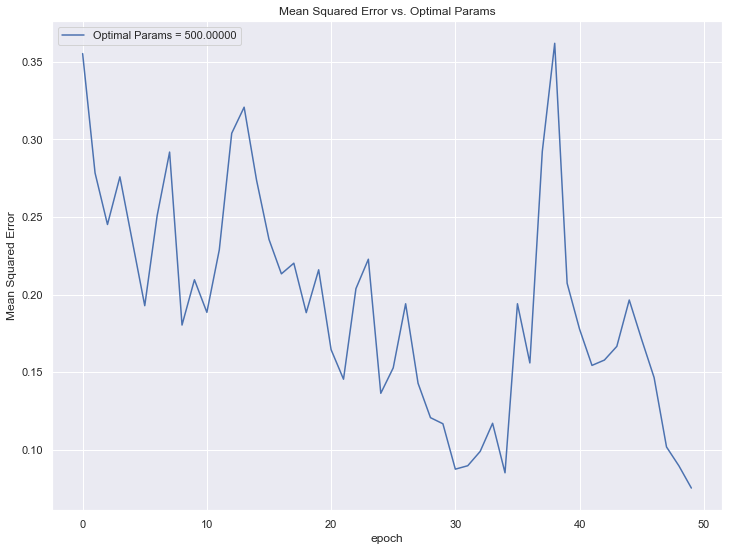

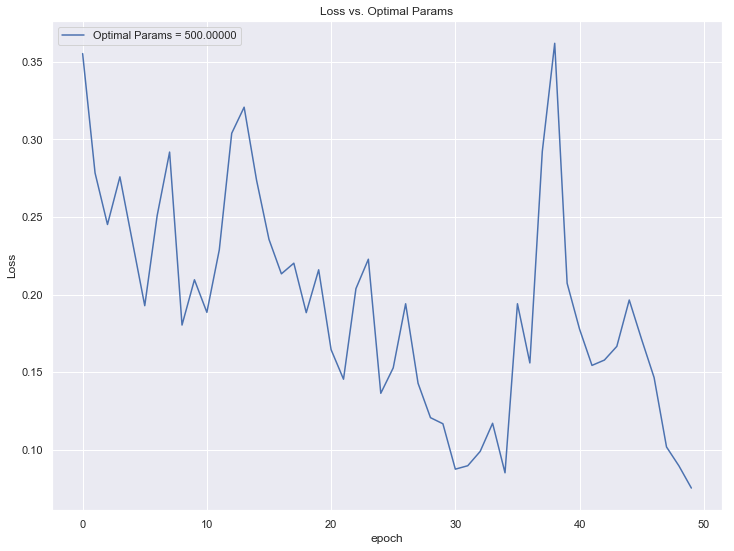

In [65]:
# still worse then 100 .. how about we use 50 epochs 
all_history = {}
plt.rcParams['figure.figsize'] = [12, 9]

# fit the base model
lstm_model, h = fit_lstm(train_scaled, batch_size, 50, 20, lag, {'lr':.1, 'b1': 0.9, 'b2':0.999} )
all_history[ne]= h
test_rmse = get_test_rmse()
print('\t\tTest RMSE: %.3f' % (test_rmse))
    
#then plot the results
plot_training_stats(all_history, 'Optimal Params')

	(Loss, MSE, MAE) : (0.08911, 0.08911, 0.22565)
		Test RMSE: 160.734


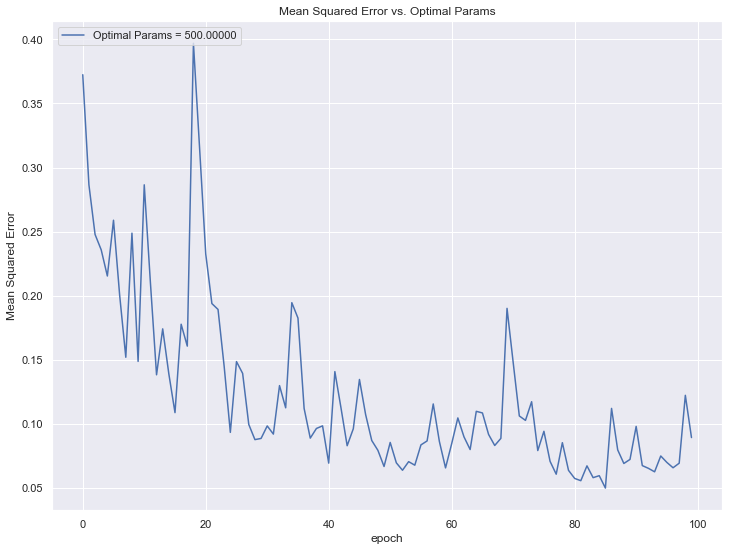

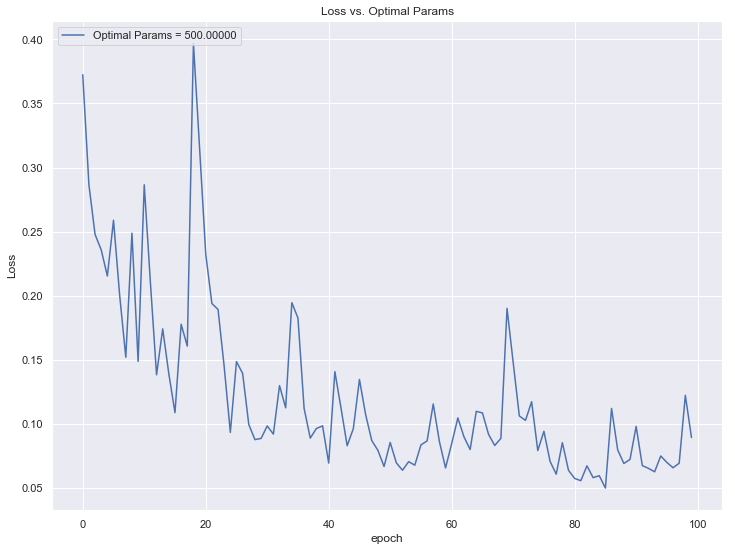

In [67]:
# that looks biased try again with 100 for a few stats sakes
all_history = {}
plt.rcParams['figure.figsize'] = [12, 9]

# fit the base model
lstm_model, h = fit_lstm(train_scaled, batch_size, 100, 20, lag, {'lr':.1, 'b1': 0.9, 'b2':0.999} )
all_history[ne]= h
test_rmse = get_test_rmse()
print('\t\tTest RMSE: %.3f' % (test_rmse))
    
#then plot the results
plot_training_stats(all_history, 'Optimal Params')

In [ ]:
# looks like we need some dispersion metrics (standard deviation e.g.) for the reported rmse 